### 1. 기본 설정

- 라이브러리

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore')

- 불러오기 (전처리 후)

In [31]:
file_path = '../전처리 완료/lendingclub 전처리 완료.csv' 

# 파일이 있는지 확인하고 로드
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
else:
    print("파일이 없습니다")

display(df.head())

,loan_amnt,term,int_rate,grade,home_ownership,annual_inc,loan_status,purpose,dti,delinq_2yrs,fico_range_low,pub_rec,revol_util
0,3600.0,36 months,13.99,C,MORTGAGE,55000.0,Fully Paid,debt_consolidation,5.91,0.0,675.0,0.0,29.7
1,24700.0,36 months,11.99,C,MORTGAGE,65000.0,Fully Paid,small_business,16.06,1.0,715.0,0.0,19.2
2,20000.0,60 months,10.78,B,MORTGAGE,63000.0,Fully Paid,home_improvement,10.78,0.0,695.0,0.0,56.2
3,35000.0,60 months,14.85,C,MORTGAGE,110000.0,Current,debt_consolidation,17.06,0.0,785.0,0.0,11.6
4,10400.0,60 months,22.45,F,MORTGAGE,104433.0,Fully Paid,major_purchase,25.37,1.0,695.0,0.0,64.5


- 한글 폰트 깨짐 방지

In [32]:
import platform
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic') 
else:
    # 리눅스
    plt.rc('font', family='NanumGothic')

# 마이너스 기호방지
plt.rcParams['axes.unicode_minus'] = False

- 결측치 확인

In [33]:
info = df.isnull().sum()
cols = info[info > 0]

if len(cols) > 0:
    print(cols)
    display(df[df.isnull().any(axis=1)])

else:
    print('결측치 없음')

결측치 없음


### 2. EDA 

#### 1. 피처 엔지니어링 

1. loan_status_binary : 이진위로 분류 (라벨 인코딩)

- fully paid(정상 상환) = 0
- charged off(부실/연체) = 1

In [35]:
df['loan_status'].value_counts()

loan_status
Fully Paid                                             1075130
Current                                                 874064
Charged Off                                             268077
Late (31-120 days)                                       21349
In Grace Period                                           8386
Late (16-30 days)                                         4331
Does not meet the credit policy. Status:Fully Paid        1953
Does not meet the credit policy. Status:Charged Off        755
Default                                                     40
Name: count, dtype: int64

In [36]:
# 1. loan_status_binary
target_status = ['Fully Paid', 'Charged Off']
df = df[df['loan_status'].isin(target_status)]

loan_status_mapping = {
    'Fully Paid': 0,
    'Charged Off': 1
}

df['loan_status_binary'] = df['loan_status'].map(loan_status_mapping)

df['loan_status_binary']

0          0
1          0
2          0
4          0
5          0
          ..
2254074    0
2254076    0
2254077    1
2254078    0
2254083    1
Name: loan_status_binary, Length: 1343207, dtype: int64

2. LTI : 내 연봉 대비 대출금이 얼마인가? (대출금 / 연소득) (파생변수)

In [37]:
# 2. LTI (Loan to Income)
# 공식: 대출금액 / 연소득
df['LTI'] = df['loan_amnt'] / df['annual_inc']
df['LTI']

0          0.065455
1          0.380000
2          0.317460
4          0.099585
5          0.351471
             ...   
2254074    0.138462
2254076    0.162618
2254077    0.203822
2254078    0.106667
2254083    0.218182
Name: LTI, Length: 1343207, dtype: float64

3. 등급 수치화: A는 1등급, G는 7등급 (숫자가 클수록 위험) ---> 라벨 인코딩 

In [38]:
df['grade']

0          C
1          C
2          B
4          F
5          C
          ..
2254074    B
2254076    C
2254077    C
2254078    C
2254083    C
Name: grade, Length: 1343207, dtype: object

In [ ]:
# 3. 등급 수치화 -->  알파벳 등급을 점수로 --> 라벨 인코딩 
# A(우량) = 1점 ~ G(위험) = 7점 (숫자가 클수록 위험함)
grade_dic = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df['grade_num'] = df['grade'].map(grade_dic)

df['grade_num']

0          3
1          3
2          2
4          6
5          3
          ..
2254074    2
2254076    3
2254077    3
2254078    3
2254083    3
Name: grade_num, Length: 1343207, dtype: int64

4. term 컬럼에서 '36개월 이상' 같은 문자열을 36이라는 숫자열로 변환하고 이름은 그대로사용 --> 전처리

In [40]:
df['term']

0           36 months
1           36 months
2           60 months
4           60 months
5           36 months
              ...    
2254074     60 months
2254076     60 months
2254077     60 months
2254078     60 months
2254083     60 months
Name: term, Length: 1343207, dtype: object

In [41]:
# 4. term -> int
# 앞뒤 공백 제거
df['term'] = df['term'].str.strip()
df['term'].unique()

# 'months' 제거 후 숫자로 변환
df['term_num'] = df['term'].str.replace(' months', '').astype(int)
df['term_num'].unique()

df['term_num']

0          36
1          36
2          60
4          60
5          36
           ..
2254074    60
2254076    60
2254077    60
2254078    60
2254083    60
Name: term_num, Length: 1343207, dtype: int64

5. home_ownership: ('MORTGAGE',  'OWN' 소유:0), ('ANY', 'RENT' ,'NONE', 'OTHER' 미소유:1) --> 라벨 인코딩

In [12]:
df['home_ownership']

0          MORTGAGE
1          MORTGAGE
2          MORTGAGE
4          MORTGAGE
5              RENT
             ...   
2257141         OWN
2257143    MORTGAGE
2257144    MORTGAGE
2257145        RENT
2257150        RENT
Name: home_ownership, Length: 1344075, dtype: object

In [42]:
map_home_ownership = {
    'MORTGAGE': 0, 'OWN':0, 'ANY':1, 'RENT': 1, 'NONE': 1, 
    'OTHER' : 1
}
map_home_ownership = df['home_ownership'].map(map_home_ownership)
df['map_home_ownership']=map_home_ownership

df['map_home_ownership']

0          0
1          0
2          0
4          0
5          1
          ..
2254074    0
2254076    0
2254077    0
2254078    1
2254083    1
Name: map_home_ownership, Length: 1343207, dtype: int64

- 파생변수 생성 확인

In [12]:
# 확인
df[['loan_status_binary', 'LTI', 'grade_num', 'term_num', 'map_home_ownership']].head(3)

,loan_status_binary,LTI,grade_num,term_num,map_home_ownership
0,0,0.065455,3,36,0
1,0,0.380000,3,36,0
2,0,0.317460,2,60,0


#### 2. 분석 / 시각화

- 종속변수 (loan_status_binary) 

완납한 사람 (Fully Paid) VS 미납한 사람(Charged Off)의 비율

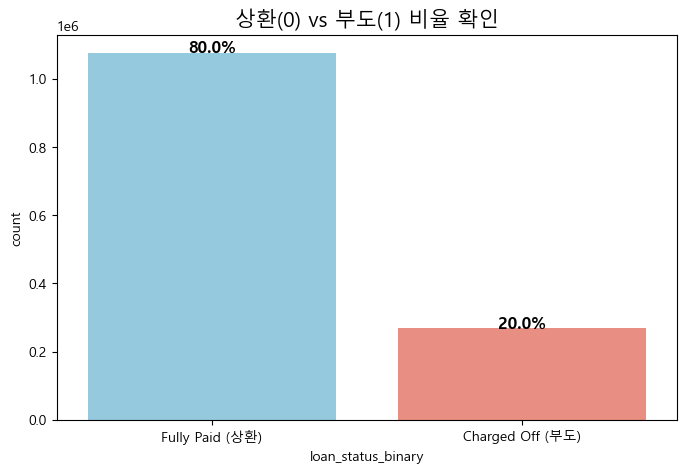

In [19]:
plt.figure(figsize=(8, 5))
custom = ['skyblue', 'salmon'] 
ax = sns.countplot(x='loan_status_binary', data=df, palette=custom) # 상환자: skyblue 부도자: salmon

# 그래프 위에 퍼센테이지 표시하는 코드
total = len(df) 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1000, 
            f'{height/total:.1%}', ha="center", fontsize=12, fontweight='bold')

plt.title('상환(0) vs 부도(1) 비율 확인', fontsize=15)
plt.xticks(ticks=[0, 1], labels=['Fully Paid (상환)', 'Charged Off (부도)'])
plt.show()

##### 1. [원본 변수] 수치형 데이터 분석

1. 대출금액 (loan_amnt): 큰돈을 빌린 사람이 갚기 더 힘들었을까?

-  데이터가 들쭉날쭉하지 않고, 1분위부터 6분위까지 계단식으로 꾸준히 상승하고 있는데 이는 '대출 금액'과 '부도율' 사이에 강한 양의 상관관계가 존재함을 시사

- 7~9분위: 22% 대에서 잠시 정체(Plateau)되는 구간이 보인 후에

- 10분위: 다시 24.5로 껑충 뜀 가장 큰 금액을 빌린 사람들은 그만큼 상환 부담이 임계치를 넘어설 가능성이 크다는 것을 보여줌.

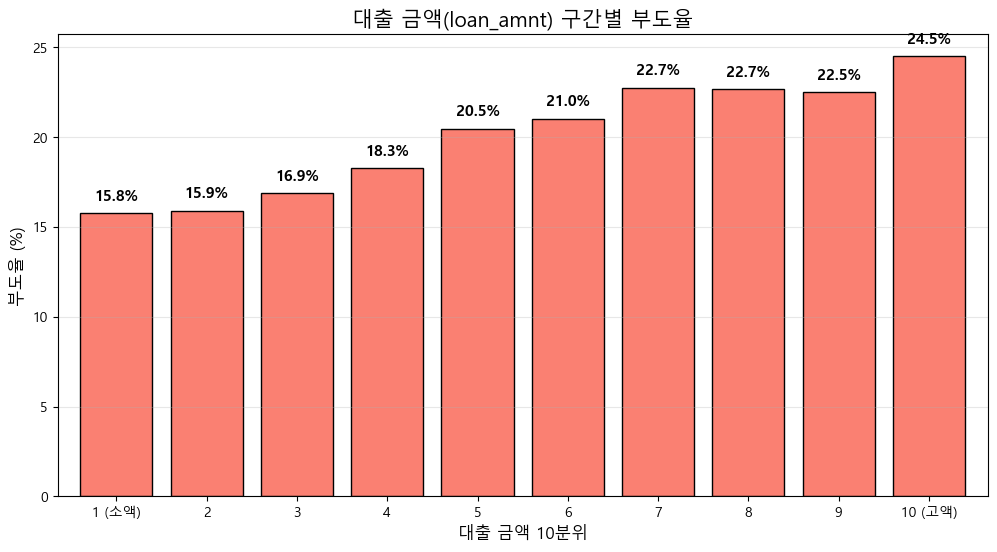

In [ ]:
# 10분위수로 나누기 (1(소액) ~ 10(고액))
amnt_labels = ['1 (소액)', '2', '3', '4', '5', '6', '7', '8', '9', '10 (고액)']
df['amnt_bin'] = pd.qcut(df['loan_amnt'], 10, labels=amnt_labels)

amnt_risk = df.groupby('amnt_bin')['loan_status_binary'].mean() * 100 # 부도율 계산

plt.figure(figsize=(12, 6))
ax = amnt_risk.plot(kind='bar', color='salmon', edgecolor='black', width=0.8)

# 퍼센트 표시
for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x() + p.get_width() / 2, 
            y = height + 0.5, 
            s = f'{height:.1f}%', 
            ha = 'center', va = 'bottom', 
            fontsize = 11, fontweight = 'bold')

plt.title('대출 금액(loan_amnt) 구간별 부도율', fontsize=15)
plt.xlabel('대출 금액 10분위', fontsize=12)
plt.ylabel('부도율 (%)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.show()

2. 부채 상환 비율 (dti): 빚이 이미 많은 사람이 또 빌렸을 때 부도가 날까?  

- 소득 대비 빚이 많을수록 부도율이 증가하는 정석적인 패턴을 보여준다. 이는 LTI 분석 결과를 뒷받침하는 보조 근거

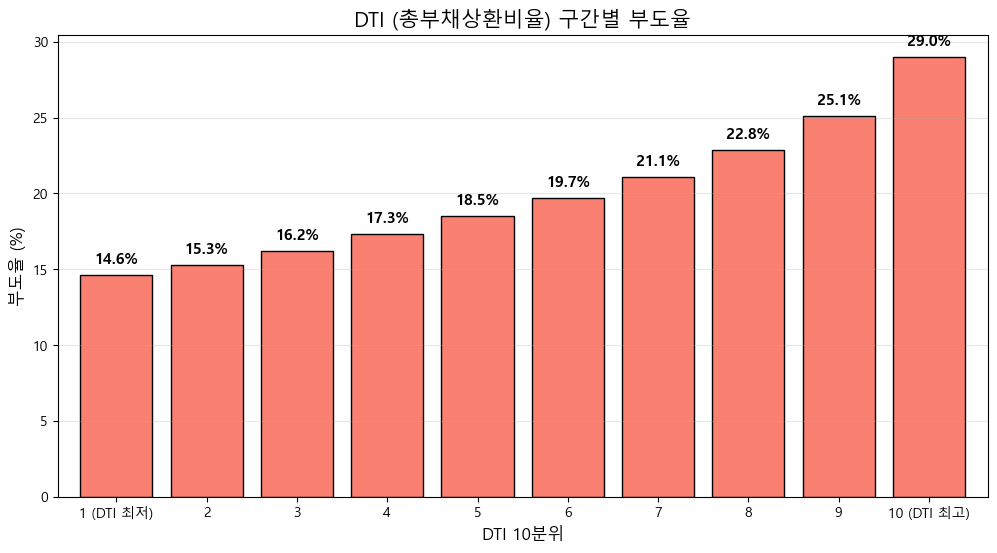

In [ ]:
# 10분위수로 나누기 (1(최저) ~ 10(최고))
dti_labels = ['1 (DTI 최저)', '2', '3', '4', '5', '6', '7', '8', '9', '10 (DTI 최고)']
df['dti_bin'] = pd.qcut(df['dti'], 10, labels=dti_labels)

dti_risk = df.groupby('dti_bin')['loan_status_binary'].mean() * 100

plt.figure(figsize=(12, 6))
ax = dti_risk.plot(kind='bar', color='salmon', edgecolor='black', width=0.8)

# 바위에 퍼센트
for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x() + p.get_width()  / 2, 
            y = height + 0.5, 
            s = f'{height:.1f}%', 
            ha = 'center', va = 'bottom', 
            fontsize = 11, fontweight = 'bold')

plt.title('DTI (총부채상환비율) 구간별 부도율', fontsize=15)
plt.xlabel('DTI 10분위', fontsize=12)
plt.ylabel('부도율 (%)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.show()

In [17]:
df['fico_range_low']

0          675.0
1          715.0
2          695.0
4          695.0
5          690.0
           ...  
2257141    735.0
2257143    705.0
2257144    735.0
2257145    665.0
2257150    660.0
Name: fico_range_low, Length: 1344075, dtype: float64

3. 신용점수(Fico)가 부도에 미치는 영향

- 신용점수가 높을수록 부도율이 순차적으로 내려가는 모습으로 

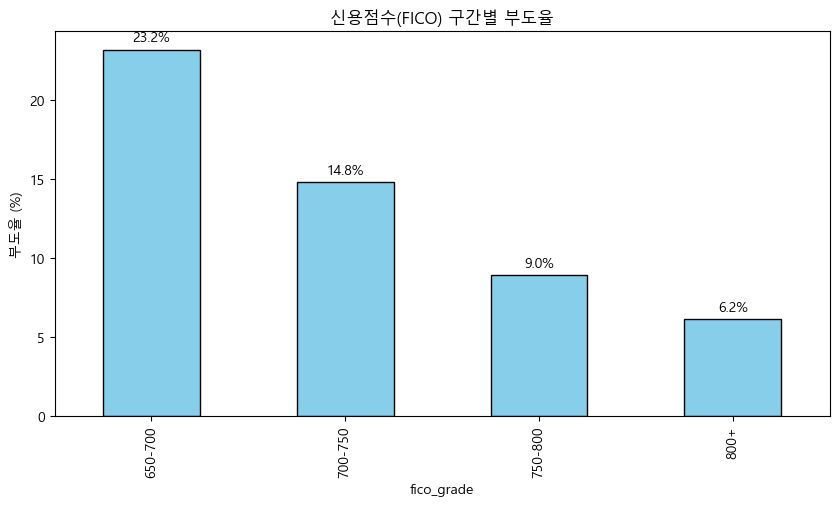

In [29]:
# 신용점수(FICO)가 부도에 미치는 영향 
bins = [650, 700, 750, 800, 850]
labels = ['650-700', '700-750', '750-800', '800+']
df['fico_grade'] = pd.cut(df['fico_range_low'], bins=bins, labels=labels)

plt.figure(figsize=(10, 5))
fico_risk = df.groupby('fico_grade')['loan_status_binary'].mean() * 100
ax = fico_risk.plot(kind='bar', color='skyblue', edgecolor='black')

# 퍼센트 표시
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height()+0.5, f'{p.get_height():.1f}%', ha='center')

plt.title('신용점수(FICO) 구간별 부도율')
plt.ylabel('부도율 (%)')
plt.show()

4. 대출 기간(term)별 부도율

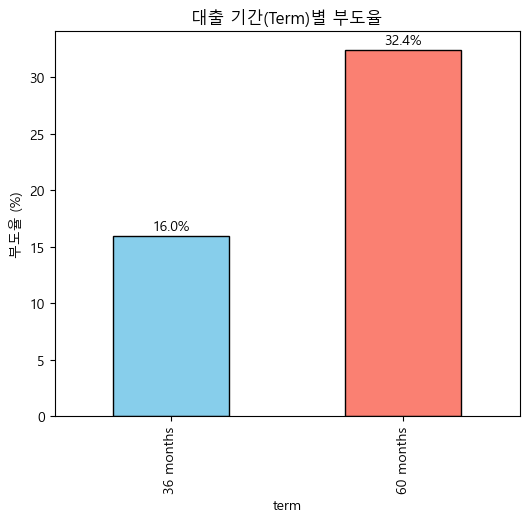

In [25]:
# 대출 기간(term) 별 부도율 
plt.figure(figsize=(6, 5))
term_risk = df.groupby('term')['loan_status_binary'].mean() * 100
ax = term_risk.plot(kind='bar', color=['skyblue', 'salmon'], edgecolor='black')
plt.title('대출 기간(Term)별 부도율')
plt.ylabel('부도율 (%)')

# 퍼센트 표시
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height()+0.5, f'{p.get_height():.1f}%', ha='center')
plt.show()

5. 이자율 (int_rate): 부도난 사람들은 애초에 고금리 대출자였을까?  ----> 이자가 높을수록 디폴트 확률이 높아짐

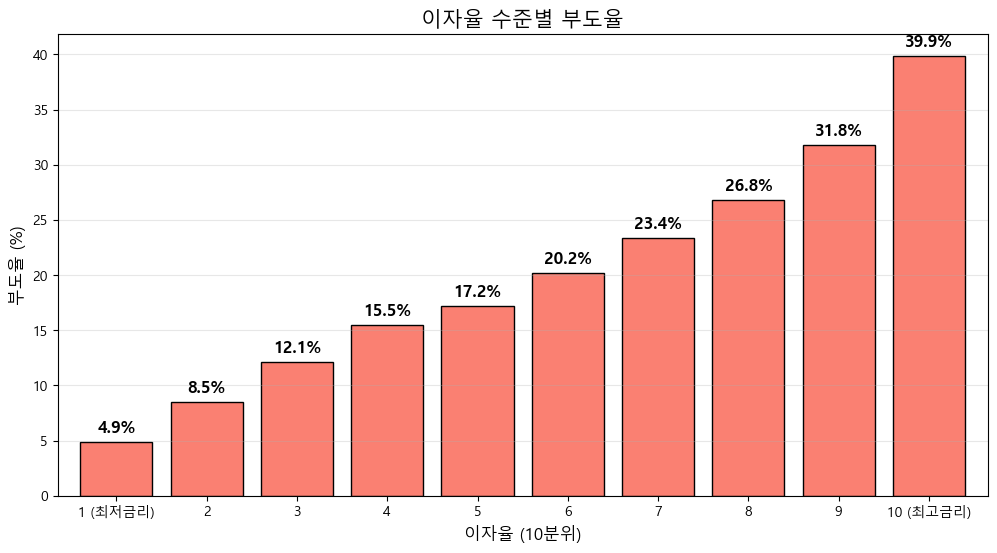

In [26]:
# 10개 분위수로 나누고 1~10 까지 라벨링
labels = ['1 (최저금리)', '2', '3', '4', '5', '6', '7', '8', '9', '10 (최고금리)']
df['int_bin'] = pd.qcut(df['int_rate'], 10, labels=labels)

# 구간별 부도율 계산
risk = df.groupby('int_bin')['loan_status_binary'].mean() * 100

plt.figure(figsize=(12, 6))
ax = risk.plot(kind='bar', color= 'salmon' , edgecolor='black', width=0.8)

# 퍼센테이지 표시
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(x = p.get_x() + p.get_width() / 2, 
                y = height + 0.5, 
                s = f'{height:.1f}%', 
                ha = 'center', va = 'bottom', 
                fontsize = 12, fontweight = 'bold')

plt.title('이자율 수준별 부도율', fontsize=15)
plt.xlabel('이자율 (10분위)', fontsize=12)
plt.ylabel('부도율 (%)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.show()

6. 연소득 (annual_inc): 돈을 못 버는 사람이 디폴트 가능성이 더 높을까?  ----> 두 그릅간의 큰 차이는 없었다 / 돈을 많이 번다고 해서 반드시 돈을 잘 갚는 것은 아님

- 박스 플롯으로 확인

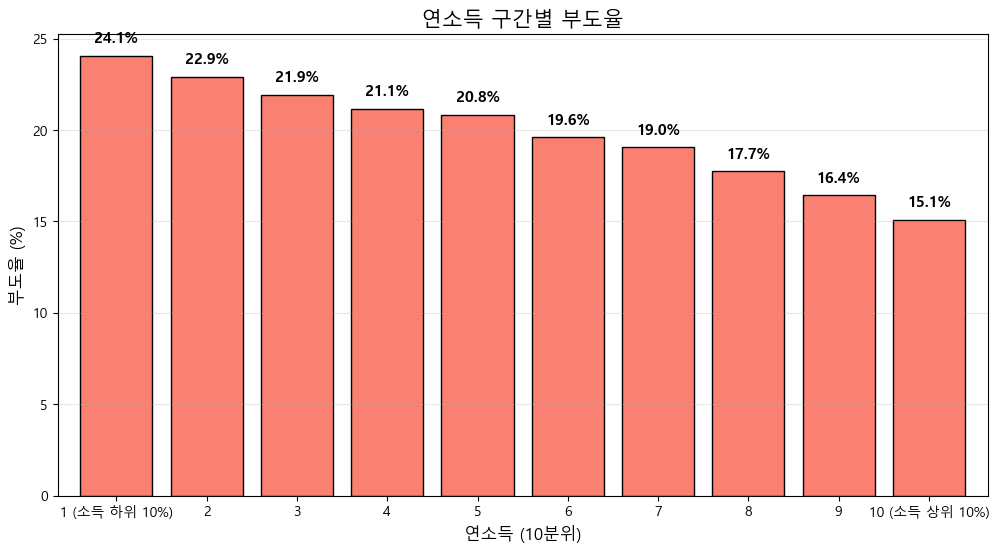

In [23]:
# 연소득 10개 분위수로 나눠 보기
inc_labels = ['1 (소득 하위 10%)', '2', '3', '4', '5', '6', '7', '8', '9', '10 (소득 상위 10%)']
df['inc_bin'] = pd.qcut(df['annual_inc'], 10, labels=inc_labels)

# 구간별 부도율 계산
inc_risk = df.groupby('inc_bin')['loan_status_binary'].mean() * 100

plt.figure(figsize=(12, 6))
ax = inc_risk.plot(kind='bar', color='salmon', edgecolor='black', width=0.8)

# 퍼센테이지 표시
for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x() + p.get_width() / 2, 
            y = height + 0.5, 
            s = f'{height:.1f}%', 
            ha = 'center', va = 'bottom', 
            fontsize = 11, fontweight = 'bold')

plt.title('연소득 구간별 부도율', fontsize=15)
plt.xlabel('연소득 (10분위)', fontsize=12)
plt.ylabel('부도율 (%)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.show()

- 파생 변수 (LTI) (KDE 그래프)

- 연 소득이나 대출금액은 예상했던 것과 달리 큰 차이점을 보이지 못함 

- 그래서 만든 파생 변수 소득 대비 대출액(LTI)은 커질수록 부도 위험군의 분포가 오른쪽(높은 쪽)으로 이동하는 것을 확인할 수 있음

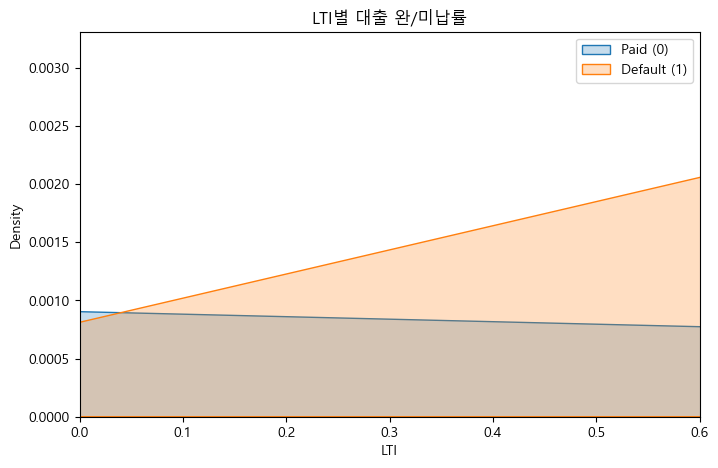

In [ ]:
plt.figure(figsize=(12, 5))
sns.kdeplot(df[df['loan_status_binary']==0]['LTI'], label='Paid (0)', shade=True)
sns.kdeplot(df[df['loan_status_binary']==1]['LTI'], label='Default (1)', shade=True)
plt.xlim(0, 0.6) 
plt.title('LTI별 부도율')
plt.legend()
plt.show()

7. 리볼빙 사용률 (revol_util) 구간별 부도율

- 카드 한도를 얼마나 썼는지가 부도에 미치는 영향을 보여줌

- 리볼빙 사용률이 높을수록(한도에 가까울수록) 부도율이 서서히 상승하는 모습

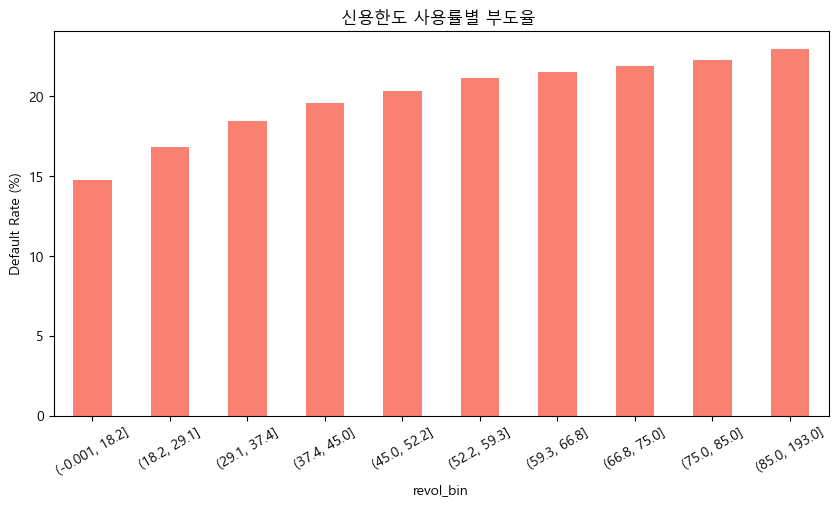

In [ ]:
df['revol_bin'] = pd.qcut(df['revol_util'], 10)  # 10분위수로 나누기
revol_risk = df.groupby('revol_bin')['loan_status_binary'].mean() * 100

revol_risk.plot(kind='bar', figsize=(10, 5), color='salmon')
plt.title('신용한도 사용률별 부도율 ')
plt.ylabel('부도율 (%)')
plt.xticks(rotation=30)
plt.show()

##### 2. [원본 변수] 범주형 데이터 분석

1. 대출 목적 (purpose): '결혼 자금' vs '사업 자금' vs '빚 갚기', 어디서 부도가 많이 날까?

- 예상대로 사업 자금 대출의 부도율이 압도적으로 높다. 사업은 성공 불확실성이 크기 때문

- 결혼이나 자동차 같은 명확한 목적이 있는 대출은 상대적으로 안전한 편

- 반면, 기존 빚을 갚기 위한 대출(대환 대출)은 의외로 부도율이 낮다. 이는 고객이 이자를 줄이고자 하는 '재무 개선 의지' 가 있기 때문으로 해석

In [ ]:
# purpose 
df['purpose'].unique()

array(['debt_consolidation', 'small_business', 'home_improvement',
       'major_purchase', 'credit_card', 'other', 'house', 'vacation',
       'car', 'medical', 'moving', 'renewable_energy', 'wedding',
       'educational'], dtype=object)

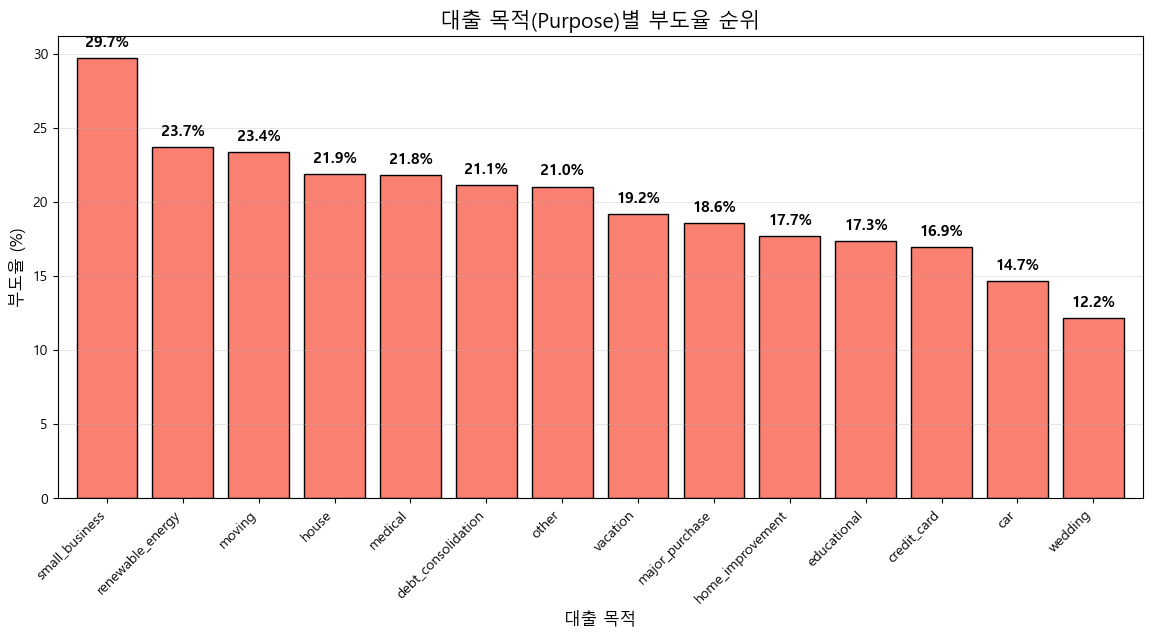

In [28]:
# 대출 목적(purpose)별 부도율 내림차순으로 
purpose_risk = df.groupby('purpose')['loan_status_binary'].mean().sort_values(ascending=False) * 100

plt.figure(figsize=(14, 6))
ax = purpose_risk.plot(kind='bar', color='salmon', edgecolor='black', width=0.8)

# 퍼센트 표시
for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x() + p.get_width() / 2, 
            y = height + 0.5, 
            s = f'{height:.1f}%', 
            ha = 'center', va = 'bottom', 
            fontsize = 11, fontweight = 'bold')


plt.title('대출 목적(Purpose)별 부도율 순위', fontsize=15)
plt.ylabel('부도율 (%)', fontsize=12)
plt.xlabel('대출 목적', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.show()

2. 내부 신용 등급(Grade)별 대출 부도율

- 기존 신용 등급이 디폴트 가능성에 대해 얼마나 큰 영향력이 있는지 보여줌
|
- 등급이 낮아질수록 부도율이 기하급수적으로 증가하며, 특히 E~G 등급은 매우 높은 위험도를 나타냄

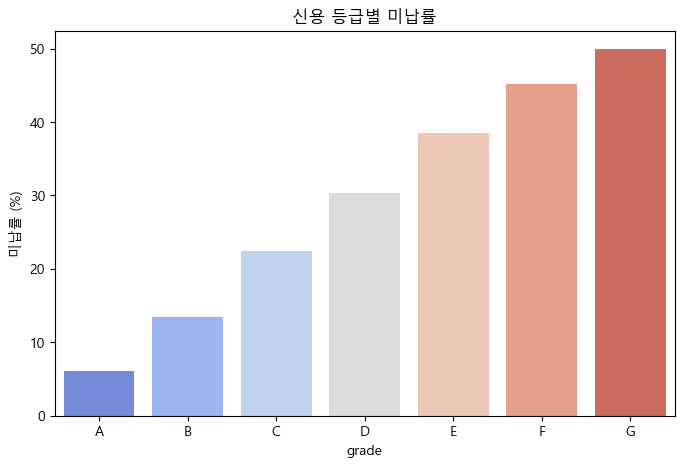

In [ ]:
grade_risk = df.groupby('grade')['loan_status_binary'].mean().sort_index() * 100

plt.figure(figsize=(8, 5))
sns.barplot(x=grade_risk.index, y=grade_risk.values, palette='coolwarm')
plt.title('내부 신용 등급별 부도율')
plt.ylabel('부도율 (%)')
plt.show()

3. 주거 형태별 부도율

- 0(자가/모기지)과 1(임대)의 차이를 보여줌

- 임대 거주자가 주택 소유자(자가/모기지 포함)보다 통계적으로 높은 부도율을 기록하여, 거주 안정성이 상환 의지에 영향을 미침을 알 수 있음

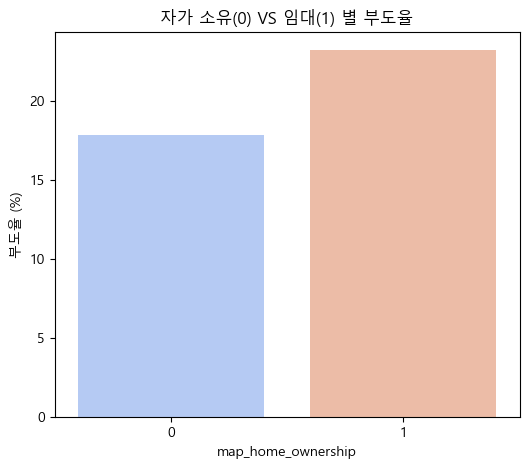

In [24]:
home_risk = df.groupby('map_home_ownership')['loan_status_binary'].mean() * 100

plt.figure(figsize=(6, 5))
colors = ['sky blue', 'salmon']
sns.barplot(x=home_risk.index, y=home_risk.values, palette='coolwarm')
plt.title('자가 소유(0) VS 임대(1) 별 부도율')
plt.ylabel('부도율 (%)')
plt.show()

##### 3. [파생 변수]

- LTI(연봉대비 대출금) 별 평균 부도율

부도율 그룹(1)의 LTI가 정상 상환자 그룹(0)보다 약 20%나 더 높다 (0.04 / 0.21 ≒ 19.7%)

In [27]:
print(df.groupby('loan_status_binary')['LTI'].mean())

loan_status_binary
0    0.210297
1    0.251801
Name: LTI, dtype: float64


- 바플롯으로 시각화

- 결론 

LTI (소득대비 부채비율)별 채무뷸이행률 계산해보니 우상향 하는 그래프가 나타남

---> 소득대비 부채비율이이 높을수록 디폴트할 가능성이 수직상승함

### 3. 통계 검정

1. LTI(소득 대비 대출 비중)는 부도 여부를 가르는 유효한 지표인가?

- 분석 종류 : 독립표본 T-검정 (Independent T-test)

- 귀무가설($H_0$): 상환자 그룹과 부도자 그룹의 평균 LTI 차이는 없다.

-  대립가설($H_1$): 부도자 그룹의 평균 LTI가 상환자 그룹보다 통계적으로 유의미하게 높을 것이다.

In [62]:
from scipy import stats

lti_paid = df[df['loan_status_binary'] == 0]['LTI'].dropna()
lti_default = df[df['loan_status_binary'] == 1]['LTI'].dropna() # 결측치가 있을 가능성으로 dropna()

# T-검정 
t_stat, p_val = stats.ttest_ind(lti_paid, lti_default, equal_var=False)

print(f"T_stat: {t_stat:.4f}")
print(f"p_value: {p_val:.10f}")

alpha = 0.05 
if p_val < alpha:
    print(f"\n[ 귀무가설 기각 / 대립가설 채택]")
    print("상환자와 부도자 그룹 간의 LTI 평균 차이는 통계적으로 매우 유의미하다")
    print("즉, LTI는 부도 여부를 결정짓는 핵심적인 지표임이 입증")
else:
    print(f"\n[ 귀무가설 채택 / 대립가설 기각 ]")
    print("두 그룹 간의 LTI 차이는 통계적으로 유의미하지 않다, (우연일 가능성 높음)")

T_stat: -23.6294
p_value: 0.0000000000

[ 귀무가설 기각 / 대립가설 채택]
상환자와 부도자 그룹 간의 LTI 평균 차이는 통계적으로 매우 유의미하다
즉, LTI는 부도 여부를 결정짓는 핵심적인 지표임이 입증


2. 리볼빙 사용률(revol_util)이 높을수록 부도 위험이 커지는가?

- 분석 종류: 독립표본 T-검정 (Independent T-test)

- 귀무가설($H_0$): 상환자 그룹과 부도자 그룹의 평균 리볼빙 사용률 차이는 없다.

- 대립가설($H_1$): 부도자 그룹의 리볼빙 사용률이 상환자 그룹보다 통계적으로 유의미하게 높을 것이다

In [ ]:
revol_paid = df[df['loan_status_binary'] == 0]['revol_util'].dropna()
revol_default = df[df['loan_status_binary'] == 1]['revol_util'].dropna()

# T-검정 
t_stat_revol, p_val_revol = stats.ttest_ind(revol_paid, revol_default, equal_var=False)
print(f"T-stat: {t_stat_revol:.4f}")
print(f"p-value: {p_val_revol:.10f}")

alpha = 0.05
if p_val_revol < alpha:
    print(f"\n[ 귀무가설(H0) 기각 / 대립가설 채택 ]")
    print("두 그룹 간의 리볼빙 사용률 차이는 '통계적으로 유의미'하다.")
    print("리볼빙 사용률은 부도 여부를 예측하는 데 유효한 변수")
else:
    print(f"\n[ 귀무가설(H0) 채택 / 대립가설 기각]")
    print("두 그룹 간의 리볼빙 사용률 차이는 '통계적으로 유의미하지 않다.")
    print("리볼빙 사용률은 부도 여부와 상관이 없거나, 차이가 우연일 가능성이 높다.")

T-stat: -71.0769
p-value: 0.0000000000

[ 귀무가설(H0) 기각 ]
두 그룹 간의 리볼빙 사용률 차이는 '통계적으로 유의미'하다.
리볼빙 사용률은 부도 여부를 예측하는 데 유효한 변수


- 결과

- T-stat -71은 통계적으로 매우 유의미한 결과이다

- 카드를 얼마나 빡빡하게 쓰고 있느냐(revol_util)가 부도를 예측하는 데 훨씬 더 결정적인 힌트가 된다는 뜻

3. 주거 형태(자가/임대)에 따라 부도 비중의 차이가 있는가?

- 분석 종류: 카이제곱 검정 (Chi-square Test)

- 귀무가설($H_0$): 주거 형태(자가/모기지 vs 임대)와 부도 여부는 서로 독립적이다(상관없다).

- 대립가설($H_1$): 주거 형태에 따라 부도율의 차이가 존재한다(서로 연관되어 있다

In [ ]:
from scipy.stats import chi2_contingency

# 교차표(contigency) 생성
contingency_table = pd.crosstab(df['map_home_ownership'], df['loan_status_binary'])

# 카이제곱 검정 실행
chi2, p_val_home, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square: {chi2:.4f}")
print(f"p-value: {p_val_home:.10f}")

alpha = 0.05
if p_val_home < alpha:
    print(f"\n[ 귀무가설 기각 / 대립가설 채택 ]")
    print("주거 형태에 따른 부도율의 차이는 통계적으로 유의미하다.")
    print("자가/모기지 여부는 부도 리스크를 판단하는 중요한 환경적 요인")
else:
    print(f"\n[ 귀무가설 채택 / 대립가설 기각]")
    print('주거 형태에 따른 부도율에 차이는 통계적으로 유의미하지 않다.')
    print('자가/모기지 여부는 부도 리스크를 판단하는 중요한 환경적 요인이 아니다.')

Chi-square: 5862.8979
p-value: 0.0000000000

[ 귀무가설 기각 ]
주거 형태에 따른 부도율의 차이는 통계적으로 유의미하다.
자가/모기지 여부는 부도 리스크를 판단하는 중요한 환경적 요인


4. 이자율(int_rate)은 실제 리스크를 정확히 반영하고 있는가?

- 분석 종류: 독립표본 T-검정 (Independent T-test)

- 귀무가설($H_0$): 상환자 그룹과 부도자 그룹이 적용받은 평균 이자율 차이는 없다.

- 대립가설($H_1$): 부도자 그룹이 적용받은 평균 이자율이 훨씬 높을 것이다.

In [ ]:
int_paid = df[df['loan_status_binary'] == 0]['int_rate'].dropna()
int_default = df[df['loan_status_binary'] == 1]['int_rate'].dropna()

# T-검정 실행
t_stat_int, p_val_int = stats.ttest_ind(int_paid, int_default, equal_var=False)
print(f"T-stat: {t_stat_int:.4f}")
print(f"p-value: {p_val_int:.10f}") 

alpha = 0.05
if p_val_int < alpha:
    print(f"\n[ 귀무가설 기각 / 대립가설 채택]")
    print("두 그룹 간의 이자율 차이는 통계적으로 매우 유의미하다.")
else:
    print(f"\n[ 귀무가설 채택 / 대립가설 기각 ]")
    print('두 그룹간의 이자율 차이는 통계적으로 의미가 없다.')

T-stat: -295.8769
p-value: 0.0000000000

[ 귀무가설 기각 ]
두 그룹 간의 이자율 차이는 통계적으로 매우 유의미하다.
이자율은 리스크를 반영하는 가장 직접적이고 강력한 지표


5. 연소득이 높을수록 부도율이 높은가?  --> 

In [ ]:
inc_paid = df[df['loan_status_binary'] == 0]['annual_inc'].dropna()
inc_default = df[df['loan_status_binary'] == 1]['annual_inc'].dropna()

# 2. T-검정 실행
t_stat_inc, p_val_inc = stats.ttest_ind(inc_paid, inc_default, equal_var=False)

print(f"T-stat: {t_stat_inc:.4f}")
print(f"p-value: {p_val_inc:.10f}")


if p_val_inc < 0.05:
    print(f"\n[ 판정: 귀무가설 기각 / 대립가설 채택 ]")
    print("상환자와 부도자 간의 연소득 평균 차이는 통계적으로 유의미")
else:
    print(f"\n[ 판정: 귀무가설 채택 / 대립가설 기각 ]")
    print("연소득 자체는 부도 여부와 통계적으로 큰 차이가 없다.")

T-stat: 50.8880
p-value: 0.0000000000

[ 판정: 귀무가설 기각 / 대립가설 채택 ]
상환자와 부도자 간의 연소득 평균 차이는 통계적으로 유의미


- 결과

<분석 대상 (변수) / 통계 검정 방법 / 검정 통계량 (Stat) / p-value / 결과 (유의성)>

1. LTI (소득 대비 부채 비중) / 독립표본 T-검정 / −23.6294 < 0.001 (채택) 

2. revol_util (리볼빙 사용률),독립표본 T-검정 / −71.0769 < 0.001 (채택) 

3. home_ownership (주거 형태) / 카이제곱 검정 / 5862.8979 < 0.001 (채택) 

4. int_rate (이자율) / 독립표본 T-검정 / −295.8769 < 0.001 / (채택)

### 4. 인사이트 및 제안 

##### 1. 신규 고객 리스크 관리

- 핵심 근거: LTI & 연소득 히트맵


    1. 만약에 LTI ≥ 30% (통계적 급증 구간)

    2. 만약에 주거 형태가  Rent라면? (자산 기반 취약) 

- 연소득과 LTI(대출금/연소득) 히트맵 

- 단순히 고소득자라고 다 안전한 게 아닌 LTI(소득대비 부채비율)가 높으면 마찬가지로 위험하다 

In [ ]:
# 전체 데이터의 LTI 분포 확인
print("전체 LTI 통계:")
print(df['LTI'].describe())

# 부도자 그룹(1)의 LTI 분포 확인
print("\n부도자 그룹의 LTI 통계:")
print(df[df['loan_status_binary']==1]['LTI'].describe())

전체 LTI 통계:
count    1.344075e+06
mean     2.185819e-01
std      1.015267e+00
min      1.714286e-04
25%      1.248545e-01
50%      2.000000e-01
75%      2.909091e-01
max      8.205128e+02
Name: LTI, dtype: float64

미상환 그룹의 LTI 통계:
count    268307.000000
mean          0.251801
std           0.735031
min           0.000436
25%           0.153150
50%           0.237624
75%           0.333333
max         260.000000
Name: LTI, dtype: float64


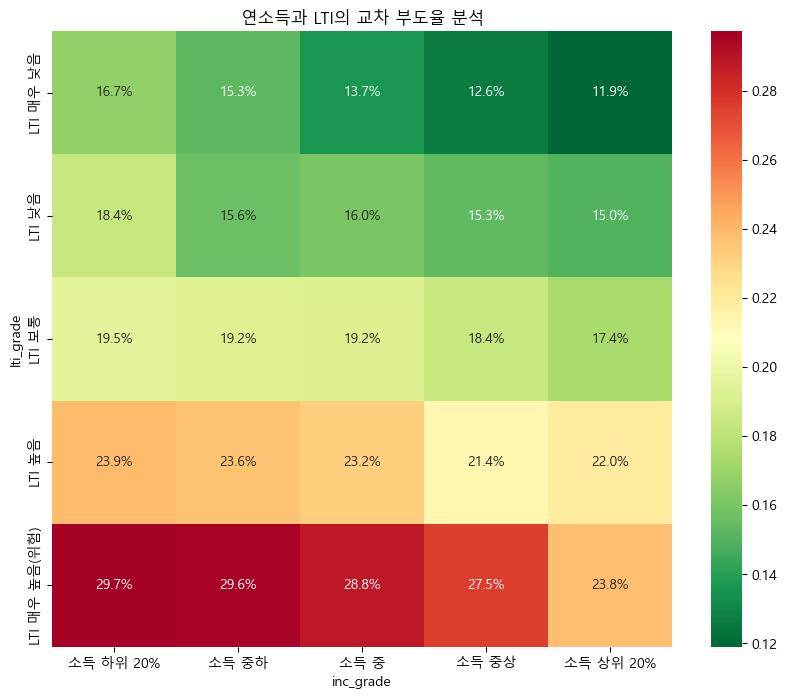

In [ ]:
# 1. 연소득과 LTI를 10분위로 나누기
df['inc_grade'] = pd.qcut(df['annual_inc'], 5, labels=['소득 하위 20%', '소득 중하', '소득 중', '소득 중상', '소득 상위 20%'])
df['lti_grade'] = pd.qcut(df['LTI'], 5, labels=['LTI 매우 낮음', 'LTI 낮음', 'LTI 보통', 'LTI 높음', 'LTI 매우 높음(위험)'])

# 2. 피벗 테이블 생성 --> 각 구간별 부도율 계산용도
heatmap_data = df.pivot_table(index=   'lti_grade', columns='inc_grade', values='loan_status_binary', aggfunc='mean')

# 히트맵 생성
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.1%', cmap='RdYlGn_r') # 붉은색일수록 위험함
plt.title('연소득과 LTI의 교차 부도율 분석')
plt.show()

- 왜 LTI 30% 이상 대출자를 '고위험군'으로 분류해야할까?

- 데이터 분석 결과, LTI가 0.3을 넘어서는 구간부터 부도율이 전 구간 대비 급격하게 상승하는 현상이 발견

-  따라서 0.3을 리스크 관리의 임계값으로 설정

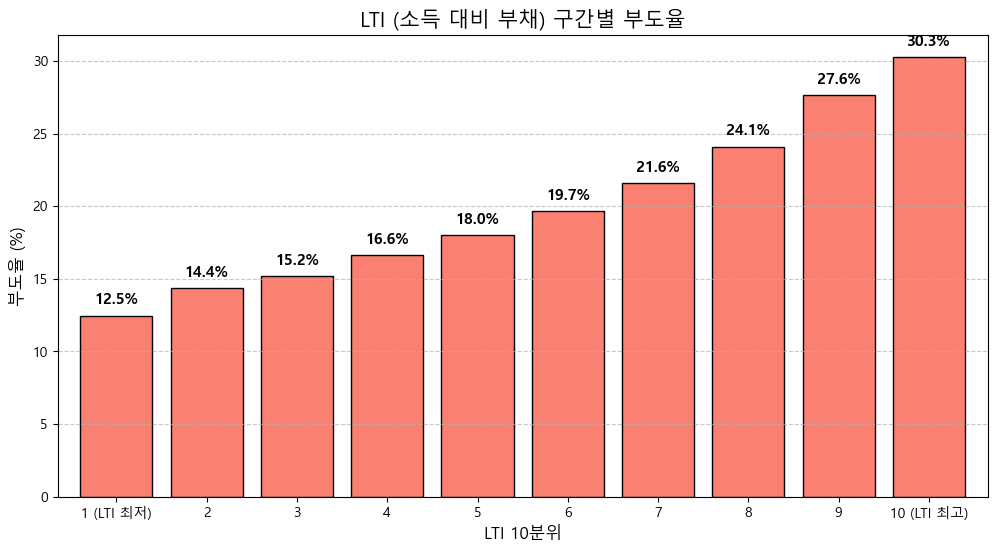

In [ ]:
# 10분위로 나누기
labels = ['1 (LTI 최저)', '2', '3', '4', '5', '6', '7', '8', '9', '10 (LTI 최고)']

df['LTI_bin'] = pd.qcut(df['LTI'], 10, labels=labels)

# 구간별 부도율 계산
lti = df.groupby('LTI_bin')['loan_status_binary'].mean() * 100

plt.figure(figsize=(12, 6))
lti.plot(kind='bar', color='salmon', edgecolor='black', width=0.8)

plt.title('LTI (소득 대비 부채) 구간별 부도율', fontsize=15)
plt.xlabel('LTI 10분위', fontsize=12)
plt.ylabel('부도율 (%)', fontsize=12)
plt.xticks(rotation=0) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 막대 위에 코드 표시
for i, v in enumerate(lti):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.show()

In [47]:
# 각 분위수마다 LTI 최댓값과 최솟값
lti_ranges = df.groupby('LTI_bin')['LTI'].agg(['min', 'max', 'count'])

print(lti_ranges)

                  min        max   count
LTI_bin                                 
1 (LTI 최저)   0.000171   0.074766  134360
2            0.074770   0.108696  134449
3            0.108699   0.138889  135053
4            0.138893   0.166667  136331
5            0.166669   0.200000  155517
6            0.200001   0.230769  113036
7            0.230770   0.267442  131507
8            0.267444   0.315789  135352
9            0.315794   0.377143  133296
10 (LTI 최고)  0.377155  20.000000  134306


- 결론 

    - 고소득자: LTI가 30% 이상인 경우 대출 한도를 축소하거나 금리를 할증

    - 저소득자: LTI가 5~10% 미만으로 아주 낮은 '알짜 고객'은 승인해 주기

    - Income과 LTI를 결합한 '승인 매트릭스' 도입

      ---> [대출 승인 거절] 또는 [한도 50% 축소]

      ---> 기대 효과: 고위험군 대출 승인율 감소 예상

####  2. 기존 고객 리스크 관리

목표: 대출 실행 후 부도 징후 조기 포착

핵심 근거: revol_util T-통계량 -71.0 

MONITORING 월별 신용카드 한도 사용률

만약에 revol_util > 80% 돌파 (위험 임계값)

---> 상환 독촉 및 추가 대출 자동 차단

---> 기대 효과: 부도 발생 전 골든타임 확보 및 회수율 증대